In [1]:
import cv2 as cv 
import numpy as np 
from matplotlib import pyplot as plt
import os
import json

### Demo/Test com OpenCV Template Match para 1 imagem

In [6]:
source_img = "./images_det/2024-10-03_000000002_jpg.rf.78a17c9e6e369373a29dd3efeb77411e.jpg"
cropped_img = "./images_rec/2024-10-03_000000002_jpg.rf.78a17c9e6e369373a29dd3efeb77411e_00.jpg"

img = cv.imread(source_img, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
img2 = img.copy()
wSource, hSource = img2.shape[::-1]

template = cv.imread(cropped_img, cv.IMREAD_GRAYSCALE)
assert template is not None, "file could not be read, check with os.path.exists()"
w, h = template.shape[::-1]

In [7]:
print(wSource)
print(hSource)

print(w)
print(h)

2296
4080
566
116


(933, 1851)
(1499, 1851)
(933, 1967)
(1499, 1967)


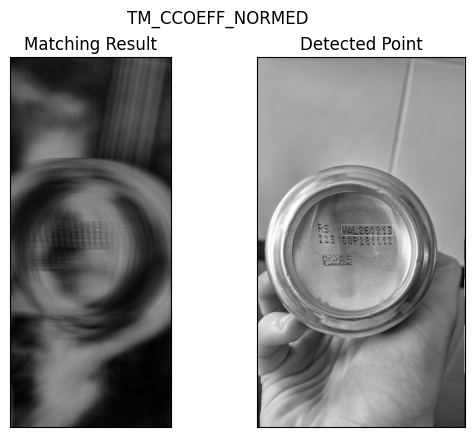

In [12]:
# All the 6 methods for comparison in a list
methods = ['TM_CCOEFF_NORMED']#, 'TM_CCOEFF', 'TM_CCORR', 'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']
 
for meth in methods:
    img = img2.copy()
    method = getattr(cv, meth)
 
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # print(min_val)
    # print(max_val)
    # print(min_loc)
    #print(max_loc)
 
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    bottom_left = (top_left[0], top_left[1] + h)
    top_right = (top_left[0] + w, top_left[1])
    
    print(top_left)
    print(top_right)
    print(bottom_left)
    print(bottom_right)

    cv.rectangle(img,top_left, bottom_right, 255, 2)
 
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
 
    plt.show()

### Script para pegar todas as bbox de data detectadas pelos executáveis 

Função p pegar a bbox usando Template Match

In [ ]:
def getBbox(source_img_path, cropped_img_path):
    
    img = cv.imread(source_img_path, cv.IMREAD_GRAYSCALE)
    assert img is not None, "file could not be read, check with os.path.exists()"
    img2 = img.copy()
    wSource, hSource = img2.shape[::-1]

    template = cv.imread(cropped_img_path, cv.IMREAD_GRAYSCALE)
    assert template is not None, "file could not be read, check with os.path.exists()"
    crop_w, crop_h = template.shape[::-1]
 
    img = img2.copy()
    method = getattr(cv, 'TM_CCOEFF_NORMED')

    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    top_left = max_loc
    bottom_right = (top_left[0] + crop_w, top_left[1] + crop_h)

    # YOLO5 PyTorch label format: class_id center_x center_y width height (coordinates are normalized from zero to one)
    x_min = top_left[0]
    y_min = top_left[1]
    center_x = (x_min + crop_w / 2) / wSource
    center_y = (y_min + crop_h / 2) / hSource

    # Calculate width and height of the bounding box (normalized)
    norm_width = crop_w / wSource
    norm_height = crop_h / hSource

    # YOLO format string: class_id center_x center_y width height
    yolo_label = f"1 {center_x:.15f} {center_y:.15f} {norm_width:.15f} {norm_height:.15f}"
    print(yolo_label)

    #cv.rectangle(img,top_left, bottom_right, 255, 2)
    #plt.subplot(121),plt.imshow(res,cmap = 'gray')
    #plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    #plt.plot(),plt.imshow(img,cmap = 'gray')
    #plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    #plt.suptitle(method)

    #plt.show()

    # YOLO5 PyTorch label format: class_id center_x center_y width height (coordinates are normalized from zero to one)
    return center_x, center_y, norm_width, norm_height

### Teste com 1 imagem 

1 0.529616724738676 0.467892156862745 0.246515679442509 0.028431372549020
(2296, 4080)


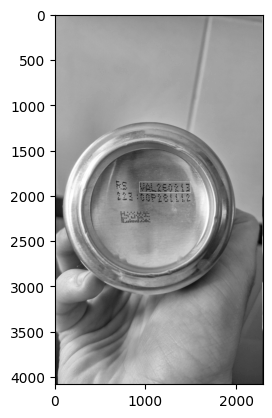

(0.5296167247386759,
 0.4678921568627451,
 0.2465156794425087,
 0.028431372549019607)

In [11]:
source_img = "./images_det/2024-10-03_000000002_jpg.rf.78a17c9e6e369373a29dd3efeb77411e.jpg"
cropped_img = "./images_rec/2024-10-03_000000002_jpg.rf.78a17c9e6e369373a29dd3efeb77411e_00.jpg"

getBbox(source_img,cropped_img)

### Laço para pegar todas as bbox 

In [3]:
# RAW_IMAGE_FOLDER = "./images_det/"
# CROPPED_IMAGE_FOLDER = "./images_rec/"
# ANNOTATIONS_FILE = "/cropped_img_list.json"
# OUTPUT_FOLDER = './dates_detected_bbox/'

RAW_IMAGE_FOLDER = "/home/landreotti/tcc/framework-execs_and_datasets/exe/2024-11-13_experimento_datasetv4/images_det/"
CROPPED_IMAGE_FOLDER = "/home/landreotti/tcc/framework-execs_and_datasets/exe/2024-11-13_experimento_datasetv4/images_rec/"
ANNOTATIONS_FILENAME = "cropped_img_list.json"
OUTPUT_FOLDER = '/home/landreotti/tcc/framework-execs_and_datasets/exe/2024-11-13_experimento_datasetv4/dates_detected_bbox/'

with open(CROPPED_IMAGE_FOLDER+ANNOTATIONS_FILENAME, 'r') as file:
    annotation_cropped_imgs = json.load(file)

annotation_detected_bbox = {}

for raw_image_name in annotation_cropped_imgs:
    cropped_img_list = annotation_cropped_imgs[raw_image_name]
    
    #criar um arquivo com nome 'raw_image_name' 
    raw_image_label_filename = raw_image_name[:-4]+".txt"

    with open(OUTPUT_FOLDER+raw_image_label_filename,'w') as raw_image_label_file:
        pass 

    annotation_detected_bbox[raw_image_name] = []
    #print(raw_image_name)

    if len(cropped_img_list) != 0:
        source_img_path = RAW_IMAGE_FOLDER+raw_image_name

        with open(OUTPUT_FOLDER+raw_image_label_filename,'a') as raw_image_label_file:

            for cropped_img_name in cropped_img_list:

                cropped_img_path = CROPPED_IMAGE_FOLDER+cropped_img_name

                # Converte coordenadas bbox para formato YOLO
                center_x, center_y, norm_width, norm_height = getBbox(source_img_path, cropped_img_path)
                #print(f'\t{center_x} {center_y} {width} {height}')
                
                annotation_detected_bbox[raw_image_name].append((cropped_img_name,[center_x, center_y, norm_width, norm_height]))
                raw_image_label_file.write(f'1 {center_x} {center_y} {norm_width} {norm_height}\n')

    else:    
        print(f"Não detectou data para imagem {raw_image_name}!!!")
    #break

#print(annotation_detected_bbox)
with open(OUTPUT_FOLDER+'annotation_detected_bbox.json','w') as outfile:
    json.dump(annotation_detected_bbox,outfile)


1 0.529616724738676 0.467892156862745 0.246515679442509 0.028431372549020
(2296, 4080)
1 0.188371080139373 0.390808823529412 0.158972125435540 0.030637254901961
(2296, 4080)
1 0.183797909407665 0.361274509803922 0.139372822299652 0.029411764705882
(2296, 4080)
1 0.237151567944251 0.234558823529412 0.132839721254355 0.024509803921569
(2296, 4080)
Não detectou data para imagem 2024-10-03_000000045_jpg.rf.6a17964db0ece5ee6a5e3932b8105e6d.jpg!!!
1 0.701655052264808 0.827205882352941 0.166376306620209 0.021078431372549
(2296, 4080)
1 0.223432055749129 0.803799019607843 0.220383275261324 0.016911764705882
(2296, 4080)
1 0.318888888888889 0.625625000000000 0.180000000000000 0.020000000000000
(900, 1600)
1 0.319444444444444 0.647500000000000 0.178888888888889 0.025000000000000
(900, 1600)
1 0.508333333333333 0.773828125000000 0.120833333333333 0.024218750000000
(960, 1280)
1 0.433455882352941 0.353440766550523 0.078676470588235 0.023954703832753
(4080, 2296)
1 0.431740196078431 0.3183797909407